In [2]:
import torch
from torch import nn, optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import splitfolders

In [3]:
def remove_corrupted_images(root_dir):
    num_deleted = 0
    for subdir, _, files in os.walk(root_dir):
        for file in files:
            filepath = os.path.join(subdir, file)
            try:
                with Image.open(filepath) as img:
                    img.verify()  # Check if image is corrupted
            except Exception as e:
                print(f"Deleting corrupted image: {filepath} ({e})")
                os.remove(filepath)
                num_deleted += 1
    print(f"\nDone! Removed {num_deleted} corrupted images.")

In [4]:
splitfolders.ratio("data", output="dataset", seed=42, ratio=(.7, .15, .15))

Copying files: 2985 files [00:01, 2468.56 files/s]


In [5]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Paths
train_dir = 'dataset/train'
val_dir = 'dataset/val'

remove_corrupted_images("dataset/train")
remove_corrupted_images("dataset/val")
#remove_corrupted_images("dataset/test")


Done! Removed 0 corrupted images.

Done! Removed 0 corrupted images.


In [7]:
#Transforms
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [8]:
# Datasets and Dataloaders
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
val_data = datasets.ImageFolder(val_dir, transform=val_transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

In [9]:
# Model
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False  # freeze everything

model.fc = nn.Linear(model.fc.in_features, len(train_data.classes))
model = model.to(device)

/Users/averyfield/Desktop/Sunfish_ID/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/averyfield/Desktop/Sunfish_ID/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
# --- Loss, Optimizer, Scheduler ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [11]:
# --- Training Loop ---
initial_epochs = 5
fine_tune_epochs = 20
total_epochs = initial_epochs + fine_tune_epochs

for epoch in range(total_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader)

    # --- Validation ---
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_acc = 100 * val_correct / val_total
    val_loss /= len(val_loader)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{total_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # --- Unfreeze and Fine-tune ---
    if epoch + 1 == initial_epochs:
        print("Unfreezing all layers for fine-tuning...")
        for param in model.parameters():
            param.requires_grad = True
        optimizer = optim.Adam(model.parameters(), lr=1e-5)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

Epoch 1/25, Train Loss: 2.2454, Train Acc: 27.83%, Val Loss: 1.8563, Val Acc: 38.10%
Epoch 2/25, Train Loss: 1.7002, Train Acc: 46.31%, Val Loss: 1.5706, Val Acc: 51.47%
Epoch 3/25, Train Loss: 1.4669, Train Acc: 54.65%, Val Loss: 1.4646, Val Acc: 51.47%
Epoch 4/25, Train Loss: 1.3201, Train Acc: 59.36%, Val Loss: 1.3909, Val Acc: 51.47%
Epoch 5/25, Train Loss: 1.2157, Train Acc: 63.10%, Val Loss: 1.3118, Val Acc: 58.96%
Unfreezing all layers for fine-tuning...
Epoch 6/25, Train Loss: 1.0635, Train Acc: 68.81%, Val Loss: 1.1864, Val Acc: 60.54%
Epoch 7/25, Train Loss: 0.9057, Train Acc: 73.42%, Val Loss: 1.0754, Val Acc: 65.76%
Epoch 8/25, Train Loss: 0.8010, Train Acc: 77.35%, Val Loss: 1.0097, Val Acc: 68.93%
Epoch 9/25, Train Loss: 0.7214, Train Acc: 80.61%, Val Loss: 0.9672, Val Acc: 69.61%
Epoch 10/25, Train Loss: 0.6362, Train Acc: 82.77%, Val Loss: 0.9337, Val Acc: 70.07%
Epoch 11/25, Train Loss: 0.5872, Train Acc: 84.64%, Val Loss: 0.8919, Val Acc: 71.43%
Epoch 12/25, Train Los

In [12]:
# --- Save model ---
torch.save(model.state_dict(), 'fish_id_finetuned.pth')
print("Model saved as 'fish_id_finetuned.pth'.")

Model saved as 'fish_id_finetuned.pth'.


In [13]:
test_dir = 'dataset/test'

remove_corrupted_images("dataset/test")

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_data = datasets.ImageFolder(test_dir, transform=test_transform)

test_loader = DataLoader(test_data, batch_size=32, shuffle=True)


Done! Removed 0 corrupted images.


In [14]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def evaluate_model(model, test_loader, device):
    # Initialize dictionaries to store correct and total predictions
    correct_pred = {classname: 0 for classname in test_loader.dataset.classes}
    total_pred = {classname: 0 for classname in test_loader.dataset.classes}

    # Set the model to evaluation mode
    model.eval()

    # Track the ground truth labels and predictions
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            # Move the inputs and labels to the device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Collect predictions and labels for metric calculations
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

            # Update the correct and total predictions
            for label, prediction in zip(labels, preds):
                classname = test_loader.dataset.classes[label]
                if label == prediction:
                    correct_pred[classname] += 1
                total_pred[classname] += 1

    # Calculate accuracy per class
    accuracy_per_class = {classname: correct_pred[classname] / total_pred[classname] if total_pred[classname] > 0 else 0
                          for classname in test_loader.dataset.classes}

    # Calculate overall accuracy
    overall_accuracy = accuracy_score(all_labels, all_preds)


    # Print the evaluation results
    print("Accuracy per class:")
    for classname, accuracy in accuracy_per_class.items():
        print(f"{classname}: {accuracy:.4f}")

    print()
    print(f"Overall Accuracy: {overall_accuracy:.4f}")



evaluate_model(model, test_loader, device)

Accuracy per class:
banded: 0.7568
blackbanded: 1.0000
blackcrappie: 0.8182
bluegill: 0.6897
bluespotted: 0.8378
green: 0.7097
largemouth: 0.9773
mud: 0.9737
pumpkinseed: 0.9231
redbreast: 0.8438
rockbass: 0.7059
smallmouth: 0.8889
warmouth: 0.6970
whitecrappie: 0.6571

Overall Accuracy: 0.8174


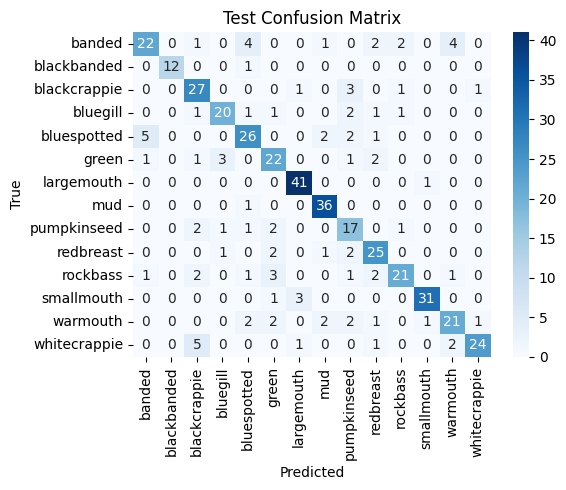

In [15]:
# --- Confusion Matrix  ---
cm = confusion_matrix(all_labels, all_preds)
class_names = train_data.classes

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Test Confusion Matrix")
plt.tight_layout()
plt.show()